# Homework 3: How similar is SARS-Cov-2 to other viruses?

Evolution is the process by which different living organisms are believed to have developed from earlier forms during the earth's history. The main component that evolves through time is the DNA which is passed on to the next generation. Genetic mutations, variation, and recombination are processes that modify DNA and cause variation in the population. The main drivers of evolution are natural selection and genetic drift that act on this variation. Through time, some characteristics become more common or rare in the population resulting in a change in heritable ones arising over successive generations.

Even though we do not consider viruses to be *living* organisms, they are still subject to evolution. Their genetic material undergoes the same transformations and selection, resulting in new variants and types of viruses.

<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Phylogenetic_tree.svg/800px-Phylogenetic_tree.svg.png" width="500">
</div>

Image source: [Wikipedia](https://en.wikipedia.org/wiki/File:Phylogenetic_tree.svg)

Comparing the characteristics of different organisms allows us to estimate their evolutionary distance. We use genetic material as a proxy for these characteristics. We estimate evolutionary distance as the number of transformation events that would occur for one organism to become genetically identical. In practice, this means aligning genetic sequences and observing the number of transformation events. Performing multiple sequence alignment and calculating pairwise distances gives us a distance matrix.

One way of presenting the evolutionary distance between organisms is with a phylogenetic tree. Similar organisms are connected via their common ancestor, even though we do not have genetic data to prove their existence. However, these common ancestors likely existed in the past due to evolution. The most common algorithms for building phylogenetic trees are the UPGMA and Neighbor-Joining algorithms. Many frequentist and Bayesian variations of these are also available online.

Once we know the evolution of the virus, we can expand our knowledge about similar viruses to our virus of interest. Our task is implementing the neighbor-joining method, a plotting function, and constructing a phylogenetic tree of coronaviruses. In the last problem, we will see how recombination can seemingly contradict the flow of evolution.

In [1]:
import numpy as np
import pandas as pd
from Bio import Entrez, SeqIO
import matplotlib.pyplot as plt

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "tm09219@student.uni-lj.si"

## Problem 1: Neighbor joining implementation

**Task:** Use the template `neighbor_joining` function in the file `helper_functions.py` and implement the neighbor-joining (NJ) algorithm for agglomerative phylogenetic clustering. Your implementation should return a `Node` object to construct a tree structure and return a root Node. Use provided classes and add code where needed. Stick to the provided structure and test your solution with added unit tests. Provided unit tests do not test the correctness of your implementation but only the structure of your output.

**Implementation requirement:** In theory, the neighbor-joining algorithm results in an unrooted tree. But for plotting and later rooting the tree, your implementation should return a root node. In the last iteration of the NJ, the algorithm joins the final two nodes by creating a root node and setting the distance to each of the remaining nodes as half of the distance between them.

(Optional) In problem 2, you will be implementing a plotting function for a phylogenetic tree. For easier visual comparison of the dendrograms, you can follow instructions in the function docstring to handle node additions and tie-breaks. Even if you handle tie-breaks differently, your implementation will be valid.

**[9 points]**

Answer the following questions about the neighbour joining algorithm:
- In some cases, the neighbour joining algorithm encounters ties in the Q-matrix when deciding which nodes to join. Can you think of an example where there are no ties (only one correct solution) when building a complete neighbour joining tree (at least 4 starting nodes)? If not, explain why.

Store your answers in the `algorithm_ties` variable.

**[1 points]**.

In [4]:
from helper_functions import neighbor_joining

In [5]:
algorithm_ties = """
Can you think of an example where there are no ties (only one correct solution) when building a complete neighbour joining tree (at least 4 starting nodes)?
If not, explain why.
There will always be ties and here is the reason: Assume we have 4 nodes (maybe we joined some together or maybe we started with 4). Label the nodes as i, j,
k and l. Then we have:
    Ri = D(i, j) + D(i, k) + D(i, l) and same for j, k, l (replace i with new letter and make sure we have no repeats in D(., .))
    M(i, j) = (4 - 2) * D(i, j) - Ri - Rj = 2 * D(i, j) - D(i, j) - D(i, k) - D(i, l) - D(j, i) - D(j, k) - D(j, l)
    M(k, l) = (4 - 2) * D(k, l) - Rk - Rl = 2 * D(k, l) - D(k, i) - D(k, j) - D(k, l) - D(l, i) - D(l, j) - D(l, k)
Since D(i, j) = D(j, i) we have
    M(i, j) = 2 * D(i, j) - D(i, j) - D(i, j) - D(i, k) - D(i, l) - D(j, k) - D(j, l) = -[D(i, k) + D(i, l) + D(j, k) + D(j, l)]
    M(k, l) = 2 * D(i, j) - D(k, l) - D(k, l) - D(i, k) - D(i, l) - D(j, k) - D(j, l) = -[D(i, k) + D(i, l) + D(j, k) + D(j, l)]
So we will have a tie between pairs (i, j) and (k, l). And we can calculate that we get the same with pairs (i, k) and (j, l), and (i, l) and (j, k).
"""

## Problem 2: Plotting a phylogenetic tree

**Task:**
Use the template `plot_nj_tree` function in the file `helper_functions.py` to write a plotting function using the `matplotlib` library.
The only limitation is to use the template function and two required inputs. How you position a dendrogram, colour the plot, labels and everything else is up to you.

Leaves in a dendrogram are connected via horizontal and vertical lines. Horizontal lines represent genetic distance, while vertical ones present divergence of the last common ancestor. Below is an example of a dendrogram. Leaves do not align on a vertical line as with hierarchical clustering.

<div>
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/dd/Phylogenetic_tree_of_coronaviruses.jpg" width="500">
</div>

*(Patrick C. Y. Woo, Yi Huang, Susanna K. P. Lau, and Kwok-Yung Yuen, [CC BY 3.0](https://creativecommons.org/licenses/by/3.0/deed.en) )*

Test your implementation to our provided unit tests by comparing your output plot to the ground truth in `tests/test_plotting_dendrogram.png`. Write your own tests as well.

**[10 points]**

In [6]:
from helper_functions import plot_nj_tree

## Problem 3: Phylogenetic analysis of coronavirus

You obtained 31 aligned sequences of different coronaviruses collected at multiple time points worldwide. We used the Clustal algorithm to provide you with a multiple sequence alignment (MSA) file in `data/clustal_MSA_coronavirus.fasta`. Each entry has a form `name|accession`.

We will use Hamming distance to calculate genetic distance from pairwise sequence alignment. This naive approach estimates the distance by counting the number of mismatches in the alignment. For example, alignment *"ATC"* and *"ATT"* will have a distance of 1 while *"AT-C"* and *"CTTC"* will have a distance of 2. There are more sophisticated approaches to evolutionary distance estimation, but for our use case, Hamming distance will suffice.

Plot a phylogenetic tree of coronaviruses using your implementation of `neighbor_joining` and `plot_nj_tree`.
Compare your results to the ones found on [Wikipedia](https://en.wikipedia.org/wiki/Coronavirus). Note that three additional viruses in our alignment file do not appear in the figure.

You might notice your figure differs from the one on Wikipedia. Neighbor-joining results in an unrooted or poorly rooted tree at best. Biologists developed a cleaver approach to determine the root of a neighbor-joining tree by including one distant relative species in the alignment, called the outgroup. In the course of evolution, a distance relative diverged first. We can determine the midpoint between the outgroup and the rest of the phylogenetic tree as a root. This approach proclaims the root node as the last common ancestor between all species in the tree. We will be using the *Breda virus* as an outgroup.

Order in a dendrogram can give an impression of a nicer plot. We can achieve this by setting the left child as the one with fewer leaf nodes in a subtree.

As a final step, fetch NCBI annotations to determine their coronavirus group. Present those groupings on your figure with colors.

**Task:** Plot the most informative phylogenetic tree by iteratively improving your implementation.

**a)** Calculate pairwise distances of aligned sequences using Hamming distance.
Construct and plot the phylogeny dendrogram using your implementations of neighbor-joining and plotting algorithm in `helper_functions`. **[4 points]**

**b)** Reroot the tree using the provided `reroot_tree` function in the `helper_function`. Use it to reroot a tree using the *Breda virus* as an outgroup. You have to fetch an outgroup from the tree first, and then use the reroot function. If you added any other relational parameters to your `Node` class, make sure you adjust the function. **[+1 points]**

**c)** Implement `sort_children_by_leaves` function in the `helper_function`. Use it to sort child nodes by assigning a left child to the one with fewer leaf nodes in their subtree. **[+1 points]**

**d)** Use color and labeling to show four major groups of coronaviruses. You can find the type of coronavirus in the NCBI annotations under the *taxonomy* field. **[+1 points]**

Save your final figure as `problem3.svg`. Make sure you save the figure using `plt.savefig('problem3.svg')` to ensure the correct format.

**[7 points in total]**

Then answer the following questions about the phylogenetic tree you have just drawn:
- To which group does SARS-CoV-2 belong? Answer using only the group name.
- Which of the following organisms would still be a valid outgroup in our case, and why?
  - Duck coronavirus 2714 (gamma coronavirus)
  - Betaarterivirus suid 1 (family Arteriviridae and order Nidovirales)
  - Homo sapiens
- Our phylogenetic tree comes without any measure of uncertainty. How would we improve our confidence in our phylogenetic relationships: would it be better to build a tree using a whole genome alignment or a consensus of several trees based on other gene alignments? Explain your reasoning.

Save your answers in the variables `sars_cov_2_group`, `valid_outgroup_choice` and `phylogenetic_uncertainty` respectively.

**[3 points]**

In [7]:
from helper_functions import reroot_tree, sort_children_by_leaves

In [8]:
# Get the sequence names and alignments to compare later
sequences = SeqIO.parse("data/clustal_MSA_coronavirus.fasta", "fasta")
sequence_names = []
covid_groups = {}
alignments = []
colors = {'Torovirus': 'tab:purple', 'Alphacoronavirus': 'tab:blue','Betacoronavirus': 'tab:orange','Gammacoronavirus': 'tab:green','Deltacoronavirus': 'tab:red'}

for sequence in sequences:
    name, index = sequence.name.split('|')
    record = SeqIO.read(Entrez.efetch(db='nucleotide', id=index, rettype='gbwithparts', retmode='text'), format='genbank')
    taxonomy = record.annotations['taxonomy'][9]
    sequence_names.append(name)
    covid_groups[name] = [colors[taxonomy], taxonomy]
    alignments.append(sequence.seq)

In [9]:
def hamming_distance(seq1, seq2):
    distance = 0

    for i in range(len(seq1)):
        distance += 1 if seq1[i] != seq2[i] else 0

    return distance

In [10]:
# Build the matrix of distances.
matrix = []

for i in range(len(sequence_names)):
    current_row = (i + 1) * [0]

    for j in range(i + 1, len(sequence_names)):
        current_row.append(hamming_distance(alignments[i], alignments[j]))

    matrix.append(current_row)

matrix = np.array(matrix)
distance_matrix = matrix + matrix.T

In [11]:
tree = neighbor_joining(distance_matrix, sequence_names)

# Reroot the tree to 'Breda' node and sort nodes so that the left (below) has fewer nodes then on top.
search = [tree]
outgroup = ''

while search != []:
    node = search.pop()
    if node.name == 'Breda':
        outgroup = node
        break
    else:
        if node.left != None:
            search.append(node.left)
        if node.right != None:
            search.append(node.right)

new_tree = reroot_tree(tree, outgroup)

# Sort the tree
sorted_tree = sort_children_by_leaves(new_tree)

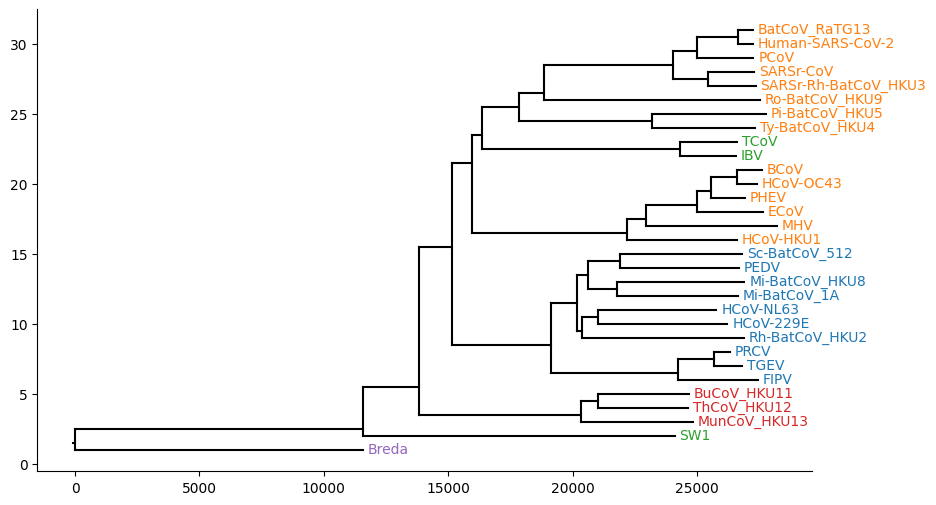

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plot_nj_tree(sorted_tree, ax, covid_groups)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('problem3.svg')

In [13]:
sars_cov_2_group = """To which group does SARS-CoV-2 belong? Answer using only the group name.
Betacoronavirus
"""

In [14]:
valid_outgroup_choice = """Which of the following organisms would still be a valid outgroup in our case, and why?
Duck coronavirus 2714 belongs to the Gammacoronaviruses family, so it would not be a valid outgroup since it is not a distant relative. While the Betaarterivirus suid 1
is not in the coronavirus family, it is still a virus. So just like Breda virus, i think this out could be classified as a valid outgroup. Since Homo sapiens is not in
the same superkingdom (Eukaryota instead of virus), it isn't a distanant relative, so using it as an outgroup would be pointless.
"""

In [15]:
phylogenetic_uncertainty = """How would we improve our confidence in our phylogenetic relationships
I think that a consensus of several trees would be better, since there could be multiple good alignments (parts), but overall the socre of the whole alignment would be bad.
In this case, with one tree we get that they differ, even though they could have a lot in common.
"""

## Problem 4: Recombination

We tend to think of evolution as a hierarchical process: we have some common ancestor that split into several sub-species through a series of random mutations. However, nothing is that straightforward in biology. There have been well-documented cases of horizontal gene transfer in nature where organisms swap entire chunks of DNA with each other. In viruses, something similar can happen as well. When a cell is infected with multiple virions (potentially different strains of the same virus), a *recombination event* can occur. Recombination occurs during the DNA copying process when, for whatever reason, the copier swaps out the virus template midway with a different template. For instance, we could start copying virus A, and then midway, the copier will switch to virus B, effectively resulting in new virus DNA that has DNA from both viruses A and B.

During the start of the global pandemic, there was much confusion about the origins of SARS-CoV-2. We initially thought it came from bats. Then, at some point, people noticed that a critical piece of the spike protein -- the receptor binding domain (RBD) -- was more similar to the sequence of pangolin coronaviruses. This evidence points to recombination. Before the virus jumped to humans, there must have been some host infected with both the Bat RaTG13 coronavirus and the Pangolin coronavirus where this recombination happened.

In this problem, we will look at the spike protein, look at the receptor binding domain, and check this evidence for recombination ourselves.

**Task**:
Find the spike proteins of the three viruses and align the sequences with each other using your global alignment implementation from the previous homework. Since we're comparing the differences between the bat and pangolin coronaviruses to the human virus, we only need to compute two alignments: human to bat and human to pangolin. We will then compare the differences between the two alignments. Find the RBD of SARS-CoV-2  using the [NCBI graphical view of the SARS-CoV-2 genome](https://www.ncbi.nlm.nih.gov/projects/sviewer/?id=NC_045512&tracks=[key:sequence_track,name:Sequence,display_name:Sequence,id:STD649220238,annots:Sequence,ShowLabel:false,ColorGaps:false,shown:true,order:1][key:gene_model_track,name:Genes,display_name:Genes,id:STD3194982005,annots:Unnamed,Options:ShowAllButGenes,CDSProductFeats:true,NtRuler:true,AaRuler:true,HighlightMode:2,ShowLabel:true,shown:true,order:9]&v=1:29903&c=null&select=null&slim=0) and look at the aminoacid similarity inside and outside the RBD. Similarly to the original publication, we will use a sliding window approach to calculate the similarity between sequences. Calculate the average number of matching amino acids for each window location in the alignment and plot the resulting similarity sequence. A window size of 100 is a good starting point. Perform this sliding window approach for both alignments and plot both similarity sequences in a single figure. Which coronavirus is more similar to SARS-CoV-2 in the RBD, and which is more similar outside the RBD? Create a visualization similar to the one in Fig. 2a from [the original Nature paper](https://www.nature.com/articles/s41586-020-2169-0)
to compare the human-to-bat and the human-to-pangolin alignments.

Save your visualization to `recombination.svg`. Make sure you save the figure using `plt.savefig('recombination.svg')` to ensure the correct format.

**[7 points]**

Then answer the following questions about recombination:
- Which coronavirus is more similar to SARS-CoV-2 inside the RBD and which is more similar outside the RBD? How did you observe this from a plot?
- If the DNA template is swapped during replication, why are we observing amino acid sequence and not nucleotide sequence similarity?
- Looking at your visualisation, are there other regions in the spike gene (or elsewhere in the genome) that could be due to recombination? Could there be an alternative explanation for the differences in these regions?

Save your answers in the variables `recombination_inside_rbd`, `recombination_aminoacid_similarity` and `recombination_other_regions` respectively.

**[3 points]**

In [16]:
from helper_functions import global_alignment
from Bio.Align import substitution_matrices

blosum62_matrix = substitution_matrices.load("BLOSUM62")

In [17]:
accession_codes = {
    "Human-SARS-CoV-2": "NC_045512",
    "Bat-CoV RaTG13": "MN996532",
    "Pangolin-CoV MP789": "MT121216",
}

In [18]:
records = []

# Get spike proteins from the records
for code in accession_codes:
    index = accession_codes[code]
    record = SeqIO.read(Entrez.efetch(db='nucleotide', id=index, rettype='gbwithparts', retmode='text'), format='genbank')
    for feature in record.features:
        if feature.type == 'CDS':
            if feature.qualifiers['gene'] == ['S']:
                records.append(feature.qualifiers['translation'][0])

In [19]:
# Calculate the alignments.
al_hb_1, al_hb_2, score_hb = global_alignment(records[0], records[1], lambda x,y: blosum62_matrix[x, y])
al_hp_1, al_hp_2, score_hp = global_alignment(records[0], records[2], lambda x,y: blosum62_matrix[x, y])

In [20]:
# Average the alignments with a sliding window of 100.
similarities_human_bat = []
similarities_human_pangolin = []

window_length = 100

# Similarities for human - bat.
for i in range(len(al_hb_1) - window_length):
    seq1 = al_hb_1[i:i + window_length]
    seq2 = al_hb_2[i:i + window_length]

    score_hb = 0

    for j in range(window_length):
        score_hb += 1 if seq1[j] == seq2[j] else 0

    similarities_human_bat.append(score_hb / window_length)

# Similarities for human - pangolin.
for i in range(len(al_hp_1) - window_length):
    seq1 = al_hp_1[i:i + window_length]
    seq2 = al_hp_2[i:i + window_length]

    score_hp = 0

    for j in range(window_length):
        score_hp += 1 if seq1[j] == seq2[j] else 0

    similarities_human_pangolin.append(score_hp / window_length)

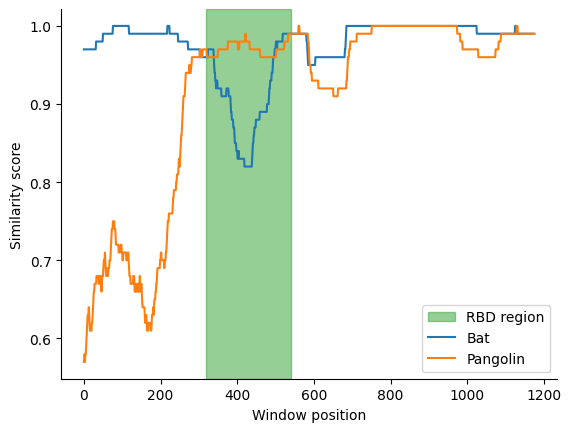

In [21]:
fig, ax = plt.subplots()
ax.axvspan(319, 541, alpha=0.5, color='tab:green', label='RBD region')
ax.plot(similarities_human_bat, label='Bat')
ax.plot(similarities_human_pangolin, label='Pangolin')
ax.spines[['right', 'top']].set_visible(False)

plt.legend()
plt.xlabel('Window position')
plt.ylabel('Similarity score')

plt.savefig('recombination.svg')

In [22]:
recombination_inside_rbd = """
Which coronavirus is more similar to SARS-CoV-2 inside the RBD and which is more similar outside the RBD?
Before the RBD, bat is more similar, but inside RBD pangolin is more similar. After the RBD part, both are very close in similarity.
"""

In [23]:
recombination_aminoacid_similarity = """
If the DNA template is swapped during replication, why are we observing amino acid sequence and not nucleotide sequence similarity?
If we have similar amino acid sequence, that means that the the nucleotide sequence will also be similar (we just save time computing it since it
is 3x shorter in length). If a nucleotide sequence is different, that means that for a given amino acid, we had either 1, 2 or 3 different nucleotides.
In some cases, difference of 1 can still be the same amino acid (TCT, TCC, TCA and TCG all map to Ser for example). On average, we will have 2 different
nucleotides per different amino acid, so our similarity score will keep the shape, but be a bit lower. 
"""

In [24]:
recombination_other_regions = """
Looking at your visualisation, are there other regions in the spike gene (or elsewhere in the genome) that could be due to recombination?
It seems that the DNA was copying the bat at the start and the swithced it out for a pangolin (th RBD part). But after that, both are very close in
similarity. So for the spike gene, I would say no.
"""

## Bonus 1: Bootstrap confidence

We performed an alignement, calulated pairwise distances and built a phylogenetic tree. Are we confident in our phylogenetic tree? The answer is, we don't know, because we never estimated the uncertainty of our solution.

In 1985, Joseph Felsenstein wrote an [article](https://pubmed.ncbi.nlm.nih.gov/28561359/) on estimating confidence limits of phylogenetic trees using a non-parametric bootstrap. It stands from the idea of creating bootstrap versions of alignment and building alternative phylogenetic trees. A confidence in a clade is then represented as a proportion of alternative trees that contain the same clade.

To generate a bootstrap version of alignment with length $N$, we sample $N$ alignment positions with replacement. Rearanging sequences accoring to a sequence of sampled indicies give us an alternative alignment. Based on new alignment we calculate the distance and apply neighbor joining algorithm to get an alternative tree.

Here we define a clade equivalence:
*Let $L$ be a set of leaf nodes in a clade from original tree and $L'$ be a set of leaf nodes in a clade from alternative tree. Let $L_1$ and $L_2$ be sets of leaf nodes of both children of a clade, such that $L = L_1 \bigcup L_2$. A clade of an alternative tree is considered the same if and only if $L = L'$ and ( $L_1 \bigcap L_1' = \emptyset\;\land\;L_2 \bigcap L_2'=\emptyset$ or $L_1 \bigcap L_2' = \emptyset\;\land\;L_2 \bigcap L_1'=\emptyset$ ).*

You are now given a Clustal mutliple sequence alignment of spike proteins from the same coronavirses as before. The alignment is store in `data/clustal_MSA_coronavirus_spike.fasta`. Again use Hamming distance for calculating distance and Breda virus as an outgroup.

**Task:** Construct a phylogenetic tree from spike protein MSA and use the bootstrap method for estimating confidence of each clade. Plot the phylogenetic tree and add confidence estimates on the plot.

**a)** Construct 100 alternative trees from bootstraped coronavirus alignments. Make sure you root your trees before estimating confidence.

**b)** Write a function to find a clade from the original tree in an alternative tree.

**c)** Calculate and asign confidence value of a clade to an attribute `Node.confidence`. Note that leaf nodes always have confidence 1.

**d)** Plot the phylogeny tree with confidence estimates using the same plotting function `plot_nj_tree` as in Problem 3. Do not plot confidence of leaf nodes.

Save your plot into `confidence_tree.svg`. Make sure you save the figure using `plt.savefig('confidence_tree.svg')` to ensure the correct format.

**[9 points]**

Then answer the following question:
- How does the phylogenetic tree compares to the one from Problem 3? Which part of the phylogenetic tree are we the least confident in?

Store your answers in the `bootstrap_comparison` variable.


**[1 points]**

In [25]:
bootstrap_comparison = """
How does the phylogenetic tree compares to the one from Problem 3? Which part of the phylogenetic tree are we the least confident in?
"""

## Bonus 2: Radial dendrogram

Use the template `plot_nj_tree_radial` function in the file `helper_functions.py` to write a plotting function for a radial dendrogram using the `matplotlib` library.

Pseudocode for radial dedrogram is provided in the [implementation article](https://kops.uni-konstanz.de/bitstream/handle/123456789/5941/bbs_dpt_05.pdf?sequence=1&isAllowed=y).

Plot the radial dedrogram for coronavirus spike protein MSA in the `data/clustal_MSA_coronavirus_spike.fasta` file.

Save your figure in `radial_dendrogram.svg`. Make sure you save the figure using `plt.savefig('radial_dendrogram.svg')` to ensure the correct format.

**[5 points]**